# *Pré-processamento*

Nessa parte, o objetivo é trabalhar com os dados de forma que eles tenham a qualidade apropriada para a análise prescritiva, exploratória e preditiva, assim, passamos por aluns processos para reduzir a multidimensionalidade e consolidar a base de dados, trabalhar com os diferentes datatypes, tratar nulos, outliers, criar novas variáveis de interesse, entre outros.
Portanto, quando finalizada essa etapa, o resultado esperado é a obtençao de um cubo de dados que sejam relevantes para a análise de risco em crédito no Brasil, com foco em inadimplencia, ou seja, nossa variável quantitativa e indicador principal é o over15. 
A fonte dos dados foi coletada dos dados abertos do Banco Central do Brasil, conforme fonte: [(https://dadosabertos.bcb.gov.br/dataset/scr_data](https://dadosabertos.bcb.gov.br/dataset/scr_data)

In [5]:
## Importação das bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings

##Ignora os erros.
with warnings.catch_warnings():
    warnings.simplefilter("ignore")


In [6]:
%matplotlib inline

In [7]:
## Cria um ambiente inicial em spark para teste do ambiente. 
## Temos os dados de crédito para um espaço de cerca de 12 anos, contendo informaçoes sobre as operaçoes de crédito no Brasil de PF e PJ.
## Informaçoes que considero relevantes para a o objetivo do projeto sao principalmente a série istórica e os indicadores de carteira ativa e inadimplencia vencida acima de 15 dias. Nesse intervalo temos uma carteira de crédito característica de atraso em eral.
## Para uma possível análise exploratória, é interessante fazer ranulometrias por estado, porte das empresas, modalidade e CNAE.
## Uma visao foto para momentos é interessante para a análise, pois nos ajuda a comparar a a realidade do crédito no Brasil em diferentes momentos.
## É interessante também comparar os resultados obtidos com o de países emerentes como Arentina, Cina, Rússia, ìndia e África do Sul.
## Também, para uma ranulometria nacional, é interessante destacar a necessidade de trazer outros indicadores socioeconomicos e ambientais que possam arear a visao de riscos. 

from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()
spark.read.csv('C:/Users/User/OneDrive - usp.br/Área de Trabalho/TCC/bacen/planilha_202404.csv', header=True,sep= ';').show()


+----------+---+--------+---+-------+--------------------+----------+--------------+--------------------+--------------------+--------------------+------------------+-------------------+--------------------+---------------------------+-----------------------------+------------------------------+------------------------------+---------------------------+------------------------+--------------+------------------------------+------------------+
| data_base| uf|     tcb| sr|cliente|            ocupacao|cnae_secao|cnae_subclasse|               porte|          modalidade|              origem|         indexador|numero_de_operacoes|a_vencer_ate_90_dias|a_vencer_de_91_ate_360_dias|a_vencer_de_361_ate_1080_dias|a_vencer_de_1081_ate_1800_dias|a_vencer_de_1801_ate_5400_dias|a_vencer_acima_de_5400_dias|vencido_acima_de_15_dias|carteira_ativa|carteira_inadimplida_arrastada|ativo_problematico|
+----------+---+--------+---+-------+--------------------+----------+--------------+--------------------+---

In [8]:
## Importaçao de bibliotecas para trabalar com funçoes de correçao, datatypes e sistema operacional.
import os
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, FloatType, IntegerType, DateType
from pyspark.sql.functions import regexp_replace, col, when, round, sum as _sum ## Possível erro. 

## Retorna uma lista com todos os caminos dos arquivos do database no OneDrive, para leitura e incorporaçao dos mesmos.
def get_csv_file_paths(root_dir):
    csv_file_paths = []
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith(".csv"):
                csv_file_paths.append(os.path.join(root, file))
    return csv_file_paths

## Inicia a sessão Spark 
spark = SparkSession.builder \
    .appName("Cube") \
    .getOrCreate()

## Diretório raiz onde os arquivos CSV estão localizados
root_dir = "C:/Users/User/OneDrive - usp.br/Área de Trabalho/TCC/bacen"

## Captura a lista de caminhos para os arquivos CSV
csv_paths = get_csv_file_paths(root_dir)

## Definir o esquema explícito, ou seja, aqui definimos os tipos de dados para cada feature, ou variável, seja contínua ou discreta.
schema = StructType([
    StructField("data_base", DateType(), True),
    StructField("uf", StringType(), True),
    StructField("tcb", StringType(), True),
    StructField("sr", StringType(), True),
    StructField("cliente", StringType(), True),
    StructField("ocupacao", StringType(), True),
    StructField("cnae_secao", StringType(), True),
    StructField("cnae_subclasse", StringType(), True),
    StructField("porte", StringType(), True),
    StructField("modalidade", StringType(), True),
    StructField("origem", StringType(), True),
    StructField("indexador", StringType(), True),
    StructField("numero_de_operacoes", StringType(), True),
    StructField("a_vencer_ate_90_dias", StringType(), True),
    StructField("a_vencer_de_91_ate_360_dias", StringType(), True),
    StructField("a_vencer_de_361_ate_1080_dias", StringType(), True),
    StructField("a_vencer_de_1081_ate_1800_dias", StringType(), True),
    StructField("a_vencer_de_1801_ate_5400_dias", StringType(), True),
    StructField("a_vencer_acima_de_5400_dias", StringType(), True),
    StructField("vencido_acima_de_15_dias", StringType(), True),
    StructField("carteira_ativa", StringType(), True),
    StructField("carteira_inadimplida_arrastada", StringType(), True),
    StructField("ativo_problematico", StringType(), True)
])

## Le múltiplos arquivos CSV usando a lista de caminhos com esquema explícito
df = spark.read.csv(csv_paths, header=True, schema=schema, sep=';')

## Substitui pontos por vírgulas nas colunas necessárias. Essa correçao só foi necessária para as variáveis quantitativas contínuas.
float_columns = [
    "a_vencer_ate_90_dias", "a_vencer_de_91_ate_360_dias", "a_vencer_de_361_ate_1080_dias",
    "a_vencer_de_1081_ate_1800_dias", "a_vencer_de_1801_ate_5400_dias", "a_vencer_acima_de_5400_dias",
    "vencido_acima_de_15_dias", "carteira_ativa", "carteira_inadimplida_arrastada", "ativo_problematico"
]

for column in float_columns:
    df = df.withColumn(column, regexp_replace(col(column), ",", ".").cast('float'))
    df = df.withColumn(column, round(col(column), 2))

## Substitui valores menores ou iguais a 15 por 15 e converter para inteiro.
## Essa correçao foi necessária devido ao número de operaçoes ser uma variável quantitativa nominal, e por isso, ser classificada como inteiro.
## Assim, assumimos como premissa que o menor número de operaçoes é 15. Dessa forma, PMEs que tenam menos operaçoes, por serem muito baixos, nao defasem na somatória. 
df = df.withColumn('numero_de_operacoes', when(col('numero_de_operacoes') == "<= 15", 15).otherwise(col('numero_de_operacoes').cast(IntegerType())))

## Filtro para carteira PJ
## Para o estudo de caso, trabalaremos somente com PMEs.
df = df.filter("cliente = 'PJ'")

## Filtro porte da empresa
df = df.filter("porte IN ('PJ - Médio                                   ', 'PJ - Micro                                   ', 'PJ - Pequeno                                 ')")

## Cria o cubo usando a função cube com múltiplas agregações
## Aqui, criamos nossa variável y, ou a feature que entendemos como alvo, ou taret. Nosso over15.
## Aqui, ao montarmos o cubo agregando os dados, reduzimos a dimensionalidade da informaçao, de forma que tenamos uma série istórica.
## Como faremos duas análises aqui, uma prescritiva exploratória e uma preditiva, teremos que criar dois cubos separados com a granulometria necessária para cada objetivo específico.
cube = df.cube("data_base").agg(
    _sum("carteira_ativa").alias("total_carteira_ativa"),
    _sum("vencido_acima_de_15_dias").alias("total_vencido_acima_de_15_dias")
)

## Filtrar e mostrar resultados onde data_base não é nulo
## Remove valores nulos que possam defasar os dados. Os valores nulos eram baixos o suficiente para lidar dessa forma.
cube = cube.filter("data_base IS NOT NULL")

## Feature engineering -> Criar a coluna de percentual de Over15
cube = cube.withColumn("over_15", 
                       (cube["total_vencido_acima_de_15_dias"] / cube["total_carteira_ativa"]) * 100)

## Drop das colunas que nao serao utilizadas para a série temporal
cube = cube.drop('carteira_ativa','vencido_acima_de_15_dias')

## Ordem decrescente
## Por ser uma série istórica, precisamos de uma ordem específica.
cube.orderBy("data_base", ascending=True)

# Converter e salva o DataFrame PySpark para Pandas
cube_pandas = cube.toPandas()
cube_pandas.to_csv('C:/Users/User/OneDrive - usp.br/Área de Trabalho/TCC/cubes/cubo_total', index=False, sep=';')
print(cube_pandas.head())

# Parar a sessão Spark
spark.stop()

    data_base  total_carteira_ativa  total_vencido_acima_de_15_dias   over_15
0  2012-06-30          6.108586e+11                    1.694424e+10  2.773841
1  2012-07-31          6.196225e+11                    1.760706e+10  2.841578
2  2012-08-31          6.213316e+11                    1.796467e+10  2.891318
3  2012-09-30          6.207200e+11                    1.686934e+10  2.717705
4  2012-10-31          6.414463e+11                    1.725200e+10  2.689547


# Análise Exploratória 

Com a base de dados, podemos realizar  uma  análise exploratória  para entender melhor a série. No presente trabalo, como estamos explorando uma série temporal, iremos começar com a visualizaçao de dados, usando boxplots, histogramas e gráficos de linha para entendendo seu comportamento, e identificando padroes. Também, usamos estatísticas  descritivas para entender a distribuiçao da série no tempo, sua autocorrelaçao, estacionaridade e decompomos a série em suas componententes de ciclo, ruído, sazonalidade e tendência. 

## Estatísticas descritivas

----------------------------------------------------------------------------------------------------
Amostragem
----------------------------------------------------------------------------------------------------
    data_base  total_carteira_ativa  total_vencido_acima_de_15_dias   over_15
0  2012-06-30          6.108586e+11                    1.694424e+10  2.773841
1  2012-07-31          6.196225e+11                    1.760706e+10  2.841578
2  2012-08-31          6.213316e+11                    1.796467e+10  2.891318
3  2012-09-30          6.207200e+11                    1.686934e+10  2.717705
4  2012-10-31          6.414463e+11                    1.725200e+10  2.689547
----------------------------------------------------------------------------------------------------
Info
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 4 columns):
 #   Col

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


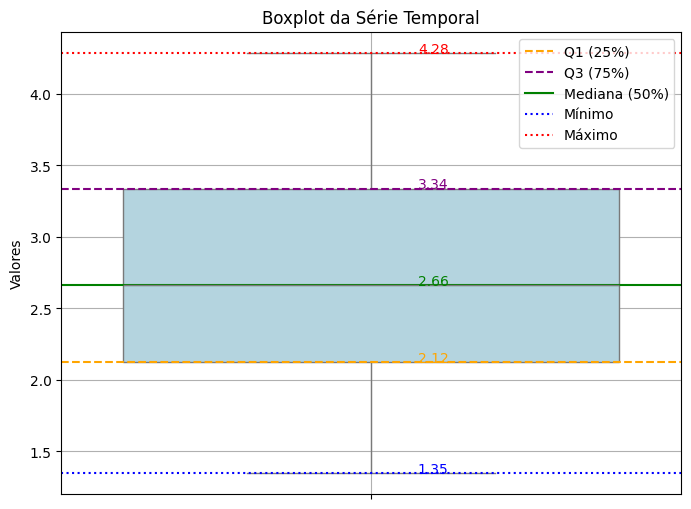

Valores Calculados
Q1: 2.1219779898352975, Q3: 3.3375636420490054, Mediana: 2.6621610017707, Mínimo: 1.3484951999297543, Máximo: 4.284587141940474


In [32]:
## oranizar as bibliotecas.
## Importação das bibliotecas
from scipy.stats import shapiro, anderson, jarque_bera, kstest, norm
from statsmodels.stats.diagnostic import het_breuschpagan, het_white, acorr_ljungbox
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm
import seaborn as sns

## Função para leitura dos dados, utilizando cunks, para otimizar a leitura.
def loadData(file):
    chunks = []
    for chunk in pd.read_csv(file, low_memory=True, chunksize=1000, sep=';', encoding='UTF-8'):
        chunks.append(chunk)
    df = pd.concat(chunks)
    return df

## Leitura do dataset
df = loadData('C:/Users/User/OneDrive - usp.br/Área de Trabalho/TCC/cubes/cubo_total')

## Visualização das estatísticas básicas
print(100*"-")
print("Amostragem")
print(100*"-")
print(df.head())

print(100*"-")
print("Info")
print(100*"-")
print(df.info())

## Como estamos olando apenas para a série temporal, vamos separar apenas a série, transformando as datas para o formato correto e resetando o indíce.
df['data_base'] = pd.to_datetime(df['data_base'])
df.set_index('data_base', inplace=True)

## Assim, temos uma série temporal com um índice de data.
series = df['over_15'] 

# Cálculo dos valores importantes
Q1 = np.percentile(series, 25)  # Primeiro quartil (Q1 - 25%)
Q3 = np.percentile(series, 75)  # Terceiro quartil (Q3 - 75%)
median = np.percentile(series, 50)  # Mediana (50%)
minimum = np.min(series)  # Mínimo
maximum = np.max(series)  # Máximo

# Boxplot
plt.figure(figsize=(8, 6))  # Definir o tamanho da figura
sns.boxplot(data=series, color='lightblue')  # Boxplot da série com cor azul clara

# Adicionando as marcações no gráfico
plt.axhline(Q1, color='orange', linestyle='--', label='Q1 (25%)')
plt.axhline(Q3, color='purple', linestyle='--', label='Q3 (75%)')
plt.axhline(median, color='green', linestyle='-', label='Mediana (50%)')
plt.axhline(minimum, color='blue', linestyle=':', label='Mínimo')
plt.axhline(maximum, color='red', linestyle=':', label='Máximo')

# Adicionando os valores ao gráfico, alinhando com as linhas
plt.text(0.1, Q1, f'{Q1:.2f}', color='orange', fontsize=10, ha='center')
plt.text(0.1, Q3, f'{Q3:.2f}', color='purple', fontsize=10, ha='center')
plt.text(0.1, median, f'{median:.2f}', color='green', fontsize=10, ha='center')
plt.text(0.1, minimum, f'{minimum:.2f}', color='blue', fontsize=10, ha='center')
plt.text(0.1, maximum, f'{maximum:.2f}', color='red', fontsize=10, ha='center')

# Definir título e rótulos do gráfico
plt.title('Boxplot da Série Temporal') 
plt.ylabel('Valores')  # Rótulo do eixo Y
plt.grid(True)  # Exibir grade no gráfico
plt.legend()  # Mostrar legenda

# Exibir o gráfico
plt.show()

# Exibir os valores calculados
print("Valores Calculados")
print(f"Q1: {Q1}, Q3: {Q3}, Mediana: {median}, Mínimo: {minimum}, Máximo: {maximum}")

## Visualizaçao Inicial

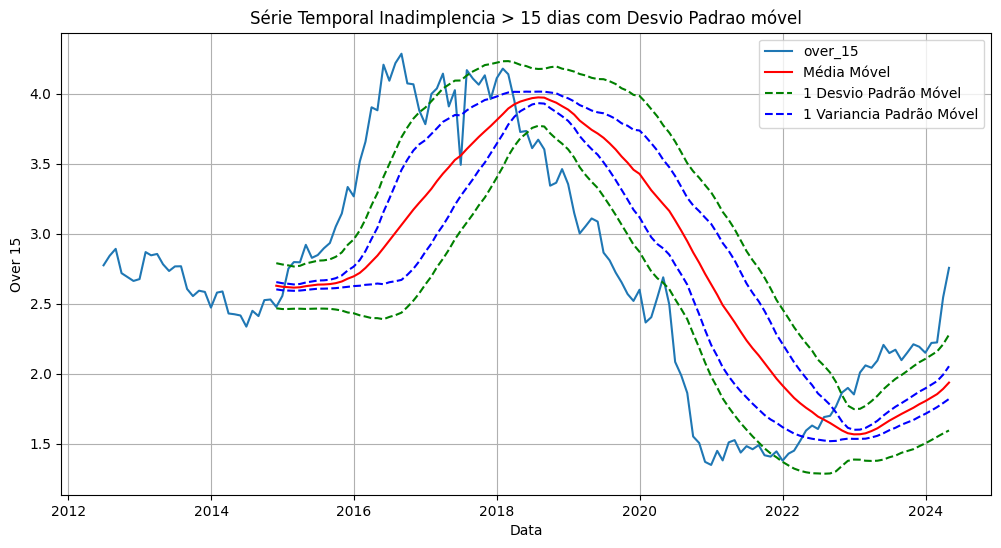

Estatística ADF: -2.173168217112373
p-valor: 0.21612754808006684
Valores críticos:
   1%: -3.4816817173418295
   5%: -2.8840418343195267
   10%: -2.578770059171598


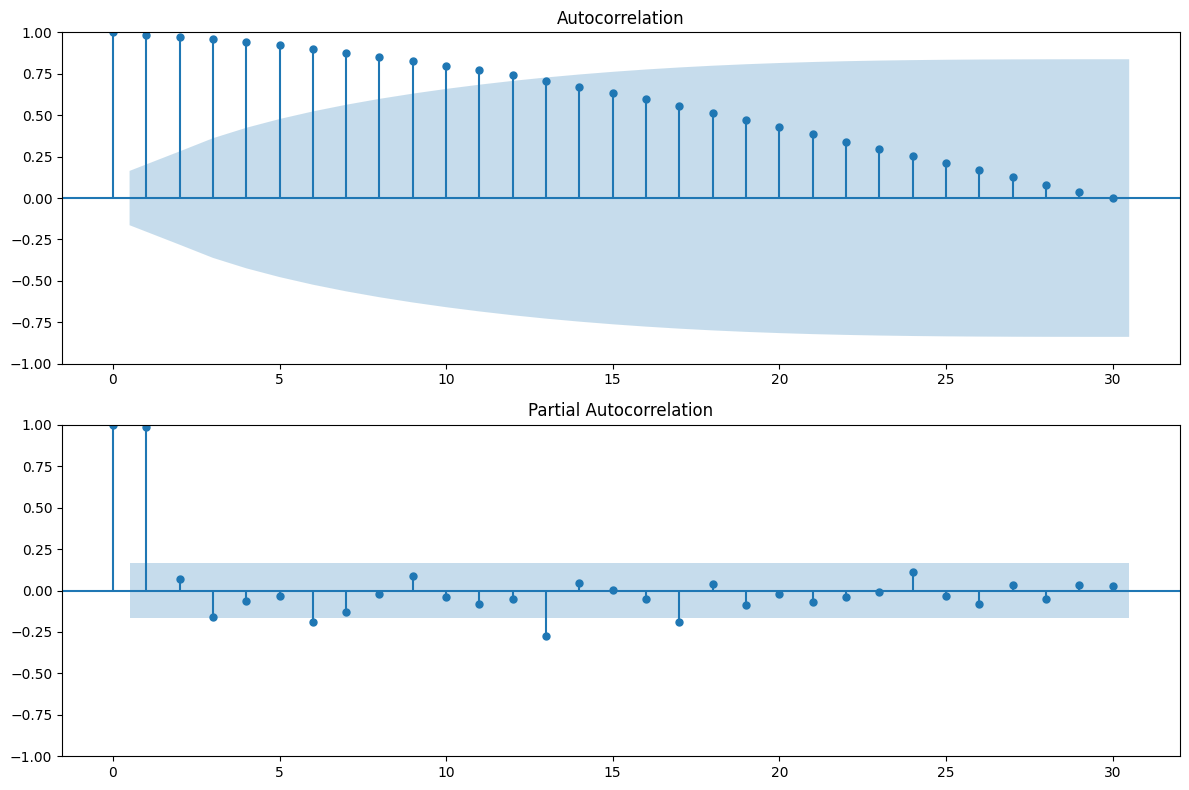

In [36]:
## Função para visualizar a série temporal com média móvel, variância e desvio padrão móveis. 
## Análise inicial da série de inadimplencia.
def plot_time_series_with_rolling_statistics(series, window=30):
    
    rolling_mean = series.rolling(window=window).mean()
    rolling_std = series.rolling(window=window).std()
    rolling_var = series.rolling(window=window).var()
    
    plt.figure(figsize=(12, 6))
    plt.plot(series, label='over_15')
    plt.plot(rolling_mean, color='red', label='Média Móvel')
    plt.plot(rolling_mean + rolling_std, color='green', linestyle='--', label='1 Desvio Padrão Móvel')
    plt.plot(rolling_mean - rolling_std, color='green', linestyle='--')
    plt.plot(rolling_mean + rolling_var, color='blue', linestyle='--', label='1 Variancia Padrão Móvel')
    plt.plot(rolling_mean - rolling_var, color='blue', linestyle='--')
    plt.title('Série Temporal Inadimplencia > 15 dias com Desvio Padrao móvel')
    plt.xlabel('Data')
    plt.ylabel('Over 15')
    plt.legend()
    plt.grid(True)
    plt.show()

## Plotagem
plot_time_series_with_rolling_statistics(series)

# Função para verificar a estacionariedade usando o teste ADF
## ADF Teste **. 
def check_stationarity(series):
    result = adfuller(series.dropna())
    print('Estatística ADF:', result[0])
    print('p-valor:', result[1])
    print('Valores críticos:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

check_stationarity(series)

## Autocorrelaçao e correlaçao parcial da série. 
# Função para plotar ACF e PACF
def plot_acf_pacf(series, lags=30):
    fig, ax = plt.subplots(2, 1, figsize=(12, 8))
    sm.graphics.tsa.plot_acf(series.dropna(), lags=lags, ax=ax[0])
    sm.graphics.tsa.plot_pacf(series.dropna(), lags=lags, ax=ax[1])
    plt.tight_layout()
    plt.show()

plot_acf_pacf(series)

## Diferenciaçao.

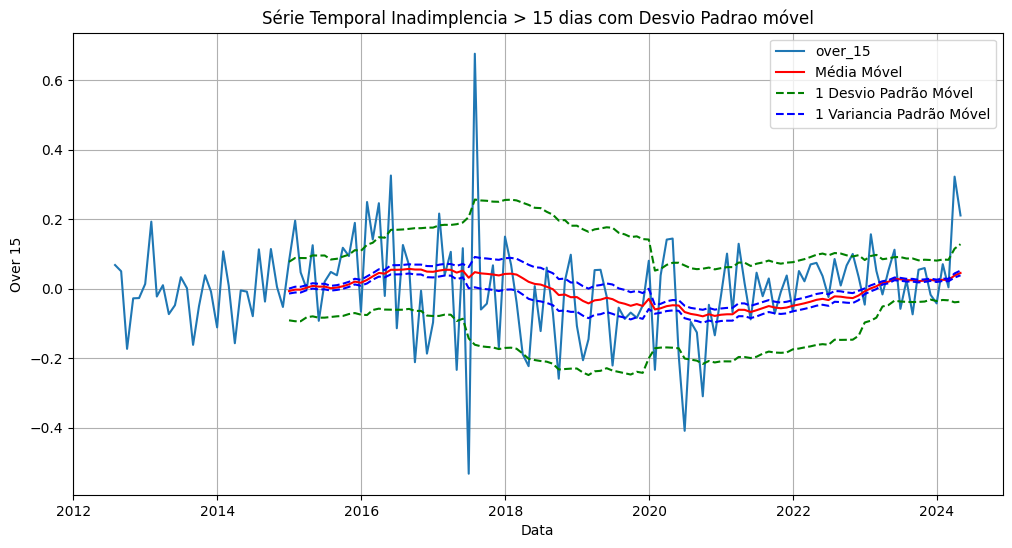

Estatística ADF: -7.012396869080002
p-valor: 6.868229263368548e-10
Valores críticos:
   1%: -3.4779446621720114
   5%: -2.8824156122448983
   10%: -2.577901887755102


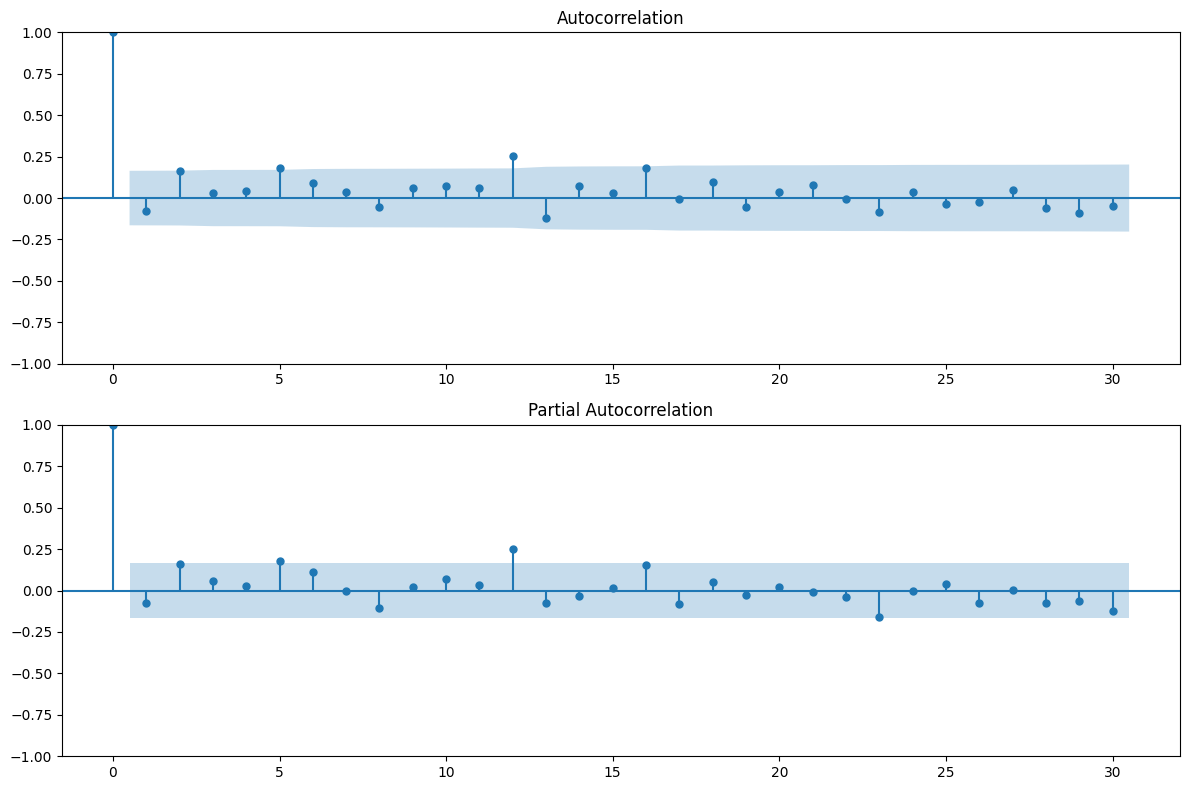

In [34]:
## Diferenciaçao

## Diferenciaçao. Colocar em um separado.
# Se a série não for estacionária, você pode diferenciar e verificar novamente
series_diff = series.diff().dropna()
plot_time_series_with_rolling_statistics(series_diff) 
check_stationarity(series_diff)
plot_acf_pacf(series_diff)

## Decomposição 

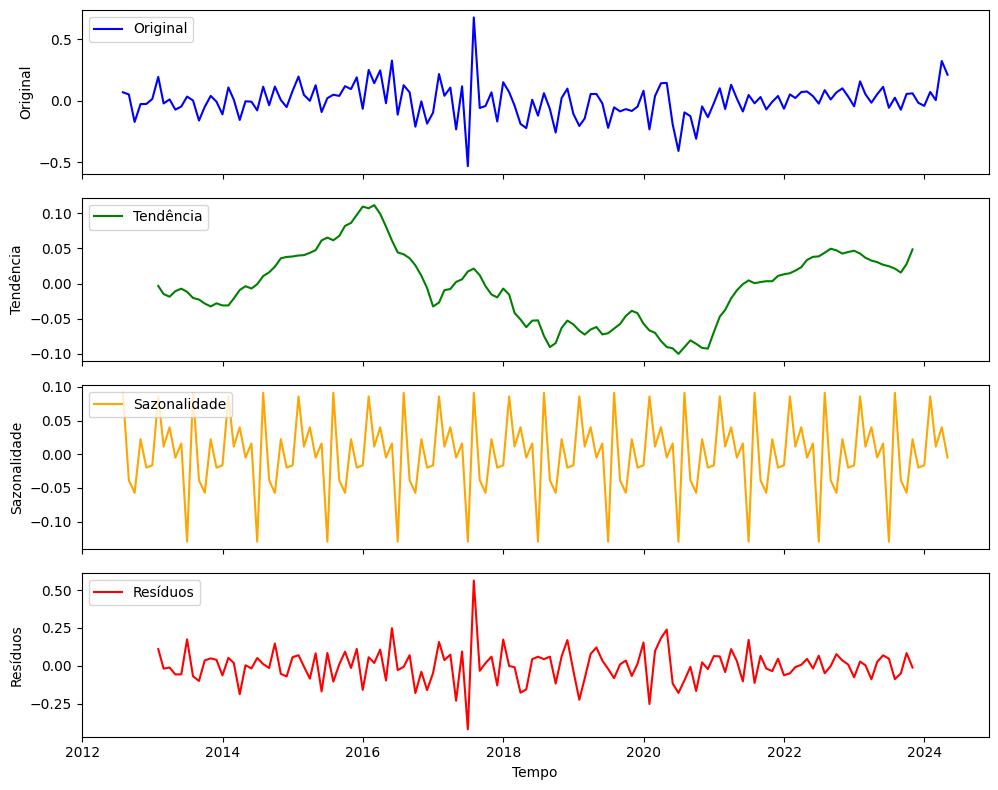

In [42]:
## Decomposiçao.
###  Decomposição da série temporal diferenciada
## Verificar o modelo multiplicativo.
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Supondo que 'series_diff' seja sua série temporal já diferenciada

# Decomposição da série temporal
decomposition = seasonal_decompose(series_diff, model='additive', period=12)

# Separando os componentes da decomposição
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Configuração da resolução do gráfico
plt.rcParams.update({'figure.figsize': (10, 8), 'figure.dpi': 100})

# Plotando os componentes individualmente
fig, axes = plt.subplots(4, 1, sharex=True)

axes[0].plot(series_diff, label='Original', color='blue')
axes[0].legend(loc='upper left')
axes[0].set_ylabel('Original')

axes[1].plot(trend, label='Tendência', color='green')
axes[1].legend(loc='upper left')
axes[1].set_ylabel('Tendência')

axes[2].plot(seasonal, label='Sazonalidade', color='orange')
axes[2].legend(loc='upper left')
axes[2].set_ylabel('Sazonalidade')

axes[3].plot(residual, label='Resíduos', color='red')
axes[3].legend(loc='upper left')
axes[3].set_ylabel('Resíduos')
axes[3].set_xlabel('Tempo')

plt.tight_layout()
plt.show()

# Treinamento dos modelos

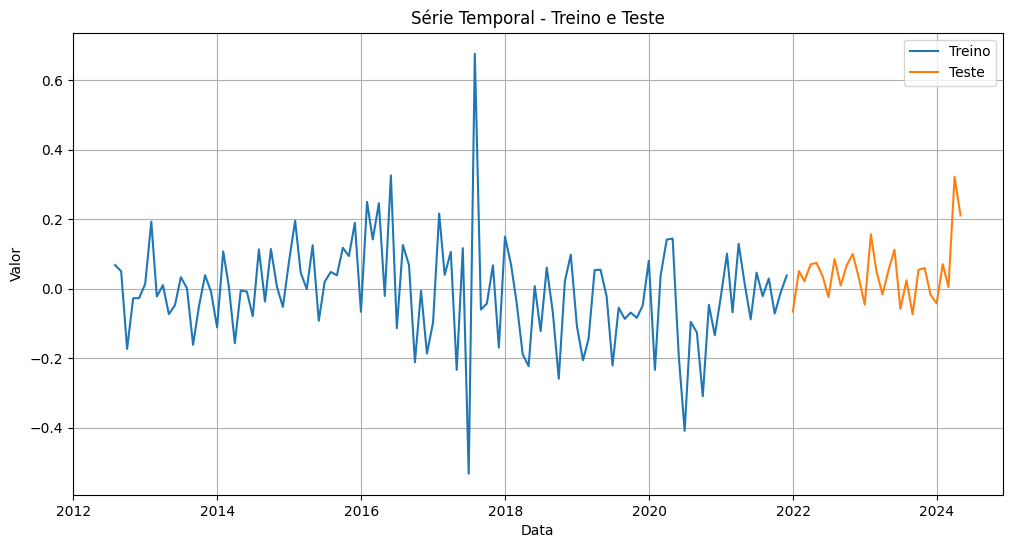

In [3]:
# Importação das bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import MinMaxScaler

# Ignorar avisos
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

# Função para leitura dos dados
def loadData(file):
    chunks = []
    for chunk in pd.read_csv(file, low_memory=True, chunksize=1000, sep=',', encoding='UTF-8'):
        chunks.append(chunk)
    df = pd.concat(chunks)
    return df

# Leitura do dataset
df = loadData('C:/Users/User/OneDrive - usp.br/Área de Trabalho/TCC/cubes/cubo_total_diff.csv')

# Assumindo que a série temporal está na coluna 'over_15_diff' e o índice de tempo está na coluna 'data_base'
df['data_base'] = pd.to_datetime(df['data_base'])
df.set_index('data_base', inplace=True)

# Seleciona a série temporal
series = df['over_15_diff'].dropna()

# Separação em treino e teste (80% treino, 20% teste)
train_size = int(len(series) * 0.8)
train, test = series.iloc[:train_size], series.iloc[train_size:]

# Função para plotar série temporal com treino e teste
def plot_train_test(train, test, title=''):
    plt.figure(figsize=(12, 6))
    plt.plot(train, label='Treino')
    plt.plot(test, label='Teste')
    plt.title(title)
    plt.xlabel('Data')
    plt.ylabel('Valor')
    plt.legend()
    plt.grid(True)
    plt.show()
## Separaçao do conjunto de dados
plot_train_test(train, test, 'Série Temporal - Treino e Teste')


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


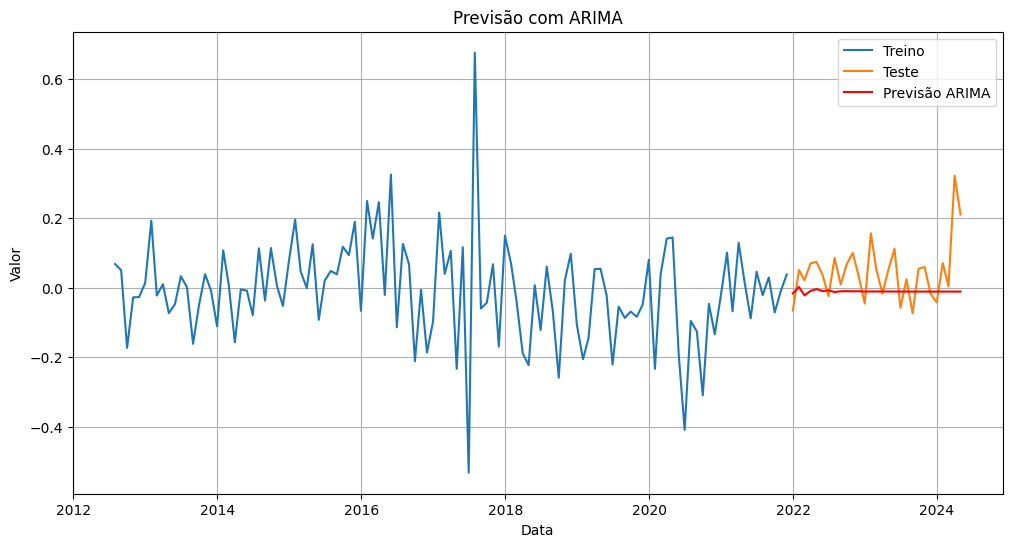

MSE: 0.00996731262348329
MAE: 0.07370089775104974


(0.00996731262348329, 0.07370089775104974)

In [8]:
## ARIMA
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Função de previsão com ARIMA
def arima_forecast(train, test):
    model = ARIMA(train, order=(5, 0, 1))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(test))
    return forecast

## Parametrizar.

# Avaliar previsões
def evaluate_forecast(test, forecast):
    mse = mean_squared_error(test, forecast)
    mae = mean_absolute_error(test, forecast)
    print(f'MSE: {mse}')
    print(f'MAE: {mae}')
    return mse, mae

# Plotar previsões
def plot_forecast(train, test, forecast, model_name):
    plt.figure(figsize=(12, 6))
    plt.plot(train, label='Treino')
    plt.plot(test, label='Teste')
    plt.plot(test.index, forecast, label=f'Previsão {model_name}', color='red')
    plt.title(f'Previsão com {model_name}')
    plt.xlabel('Data')
    plt.ylabel('Valor')
    plt.legend()
    plt.grid(True)
    plt.show()

# Exemplo de uso
forecast = arima_forecast(train, test)
plot_forecast(train, test, forecast, 'ARIMA')
evaluate_forecast(test, forecast)


In [ ]:
## SARIMA
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Função de previsão com SARIMA
def sarima_forecast(train, test):
    best_score, best_params = float("inf"), None
    for p in range(1, 4):
        for d in range(1, 2):
            for q in range(1, 4):
                for P in range(1, 3):
                    for D in range(1, 2):
                        for Q in range(1, 3):
                            for s in [6, 12]:
                                try:
                                    model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, s))
                                    model_fit = model.fit(disp=False)
                                    forecast = model_fit.forecast(steps=len(test))
                                    score = mean_squared_error(test, forecast)
                                    if score < best_score:
                                        best_score = score
                                        best_params = (p, d, q, P, D, Q, s) ## Quais sao os meliores parametros até entao?
                                except:
                                    continue

    p, d, q, P, D, Q, s = best_params
    model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, s))
    model_fit = model.fit(disp=False)
    forecast = model_fit.forecast(steps=len(test))
    return pd.Series(forecast, index=test.index)

# Avaliar previsões
def evaluate_forecast(test, forecast):
    mse = mean_squared_error(test, forecast)
    mae = mean_absolute_error(test, forecast)
    print(f'MSE: {mse}')
    print(f'MAE: {mae}')
    return mse, mae

# Plotar previsões
def plot_forecast(train, test, forecast, model_name):
    plt.figure(figsize=(12, 6))
    plt.plot(train, label='Treino')
    plt.plot(test, label='Teste')
    plt.plot(test.index, forecast, label=f'Previsão {model_name}', color='red')
    plt.title(f'Previsão com {model_name}')
    plt.xlabel('Data')
    plt.ylabel('Valor')
    plt.legend()
    plt.grid(True)
    plt.show()

forecast = sarima_forecast(train, test)
plot_forecast(train, test, forecast, 'SARIMA')
evaluate_forecast(test, forecast)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
RandomForestRegressor(max_depth=20, min_samples_leaf=2, min_samples_split=5)


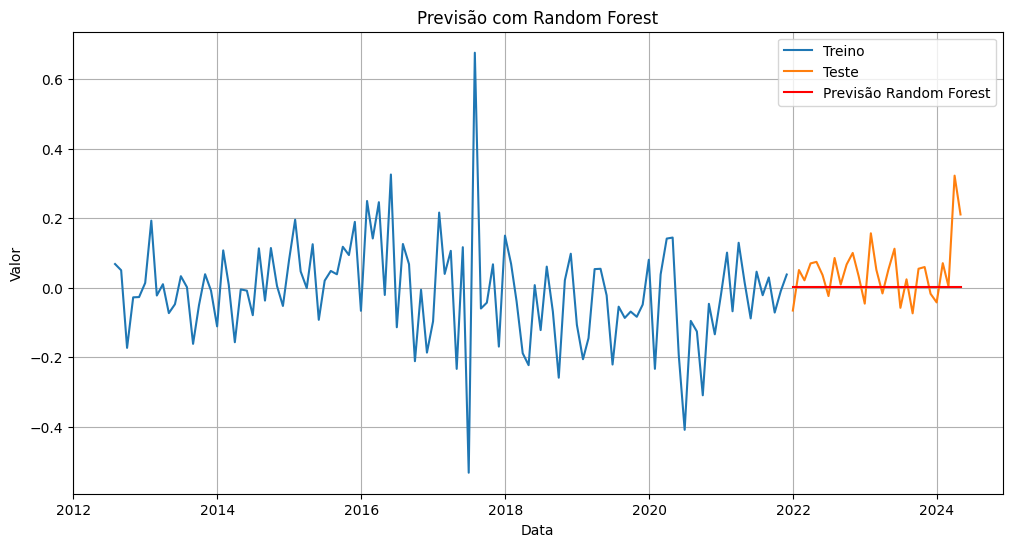

MSE: 0.008878237279460207
MAE: 0.06904433831310752


(0.008878237279460207, 0.06904433831310752)

In [70]:
## Random Forest
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV

# Função de previsão com Random Forest
def random_forest_forecast(train, test):
    train_index = np.array(train.index).reshape(-1, 1)
    test_index = np.array(test.index).reshape(-1, 1)
    
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    rf = RandomForestRegressor()
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
    grid_search.fit(train_index, train.values)

    best_rf = grid_search.best_estimator_
    forecast = best_rf.predict(test_index)
    print(best_rf)
    return pd.Series(forecast, index=test.index)

# Avaliar previsões
def evaluate_forecast(test, forecast):
    mse = mean_squared_error(test, forecast)
    mae = mean_absolute_error(test, forecast)
    print(f'MSE: {mse}')
    print(f'MAE: {mae}')
    return mse, mae

# Plotar previsões
def plot_forecast(train, test, forecast, model_name):
    plt.figure(figsize=(12, 6))
    plt.plot(train, label='Treino')
    plt.plot(test, label='Teste')
    plt.plot(test.index, forecast, label=f'Previsão {model_name}', color='red')
    plt.title(f'Previsão com {model_name}')
    plt.xlabel('Data')
    plt.ylabel('Valor')
    plt.legend()
    plt.grid(True)
    plt.show() 

# Exemplo de uso
forecast = random_forest_forecast(train, test)
plot_forecast(train, test, forecast, 'Random Forest')
evaluate_forecast(test, forecast)